In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

# Veri seti yolunu belirtelim
dataset_path = 'processed_kirpilmamis'

# Görselleri ve etiketleri yüklemek için bir dataframe oluşturalım
data = []

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            data.append([img_path, label])

df = pd.DataFrame(data, columns=['image_path', 'label'])

# Veri setini eğitim ve test olarak ayıralım
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [2]:
class MRI_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx, 1].split('_')[-1])  # Etiket klasör adından elde ediliyor
        image = Image.open(img_path).convert('L')  # Görsellerin gri tonlamalı olduğunu varsayıyorum
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Veri dönüştürücüler (transforms) tanımlayalım
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dataset ve DataLoader tanımlamaları
train_dataset = MRI_Dataset(train_df, transform=transform)
test_dataset = MRI_Dataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),
            nn.Linear(64, num_classes)  # num_classes sınıf sayısı
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.classifier(x)
        return x

# Modeli ve diğer eğitim elemanlarını tanımlayalım
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Epoch [1/50], Train Loss: 1.3612, Train Accuracy: 32.74%, Val Loss: 1.2921, Val Accuracy: 38.28%
Epoch [2/50], Train Loss: 1.2481, Train Accuracy: 42.36%, Val Loss: 1.2301, Val Accuracy: 40.11%
Epoch [3/50], Train Loss: 1.2206, Train Accuracy: 46.10%, Val Loss: 1.1712, Val Accuracy: 48.44%
Epoch [4/50], Train Loss: 1.2083, Train Accuracy: 45.87%, Val Loss: 1.3145, Val Accuracy: 35.94%
Epoch [5/50], Train Loss: 1.1911, Train Accuracy: 46.16%, Val Loss: 1.1645, Val Accuracy: 42.07%
Epoch [6/50], Train Loss: 1.1732, Train Accuracy: 47.31%, Val Loss: 1.1297, Val Accuracy: 49.88%
Epoch [7/50], Train Loss: 1.1667, Train Accuracy: 46.91%, Val Loss: 1.1257, Val Accuracy: 50.31%
Epoch [8/50], Train Loss: 1.1477, Train Accuracy: 48.08%, Val Loss: 1.1261, Val Accuracy: 46.19%
Epoch [9/50], Train Loss: 1.1517, Train Accuracy: 48.47%, Val Loss: 1.1105, Val Accuracy: 50.74%
Epoch [10/50], Train Loss: 1.1409, Train Accuracy: 48.68%, Val Loss: 1.1363, Val Accuracy: 47.92%
Epoch [11/50], Train Loss: 1.

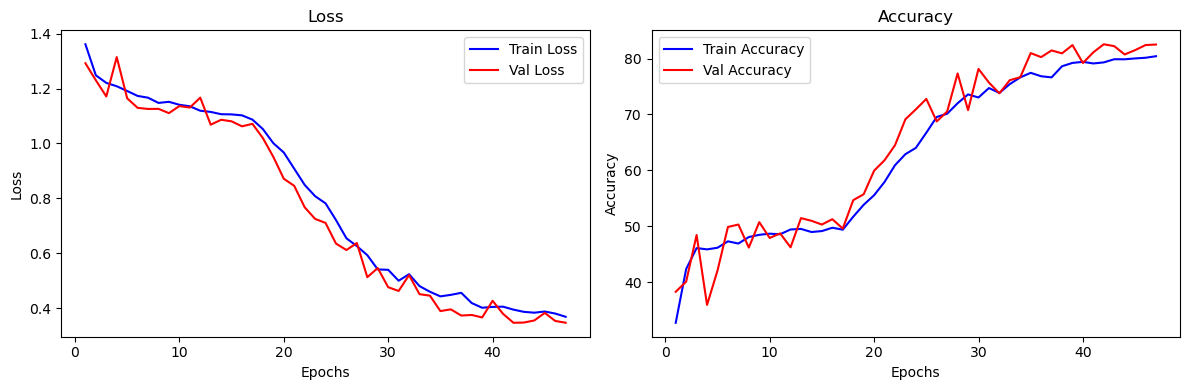

In [5]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama metriklerini kaydetme
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
patience = 5
early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Grafikleri oluşturma
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import classification_report

# Modeli eğittikten ve doğruladıktan sonra, test seti üzerinde tahminler yapıyoruz
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report'u daha fazla basamaklı göstermek için
report = classification_report(all_labels, all_preds, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9901    0.9331    0.9608       538
           1     0.9541    0.9913    0.9723       461
           2     0.7181    0.8000    0.7568       640
           3     0.6469    0.5603    0.6005       448

    accuracy                         0.8251      2087
   macro avg     0.8273    0.8212    0.8226      2087
weighted avg     0.8251    0.8251    0.8234      2087



In [6]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Değerlendirme raporu
print(classification_report(all_labels, all_preds, target_names=['label_0', 'label_1', 'label_2', 'label_3']))

              precision    recall  f1-score   support

     label_0       0.86      0.98      0.92       538
     label_1       0.99      0.80      0.89       461
     label_2       0.79      0.76      0.78       640
     label_3       0.65      0.72      0.68       448

    accuracy                           0.82      2087
   macro avg       0.83      0.81      0.82      2087
weighted avg       0.83      0.82      0.82      2087



: 

In [5]:
# Eğitim ve doğrulama döngüsünü güncelleme
num_epochs = 10
patience = 3
early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch [1/10], Train Loss: 1.2965, Train Accuracy: 38.53%, Val Loss: 1.2083, Val Accuracy: 45.49%
Epoch [2/10], Train Loss: 1.0673, Train Accuracy: 51.57%, Val Loss: 0.8325, Val Accuracy: 61.79%
Epoch [3/10], Train Loss: 0.7927, Train Accuracy: 62.70%, Val Loss: 0.6902, Val Accuracy: 66.88%
Epoch [4/10], Train Loss: 0.7037, Train Accuracy: 66.36%, Val Loss: 0.7667, Val Accuracy: 62.05%
Epoch [5/10], Train Loss: 0.6593, Train Accuracy: 69.28%, Val Loss: 0.5743, Val Accuracy: 72.64%
Epoch [6/10], Train Loss: 0.6342, Train Accuracy: 70.08%, Val Loss: 0.6735, Val Accuracy: 65.93%
Epoch [7/10], Train Loss: 0.6143, Train Accuracy: 70.45%, Val Loss: 0.6490, Val Accuracy: 66.25%
Epoch [8/10], Train Loss: 0.5819, Train Accuracy: 72.06%, Val Loss: 0.5316, Val Accuracy: 74.32%
Epoch [9/10], Train Loss: 0.5675, Train Accuracy: 72.52%, Val Loss: 0.5484, Val Accuracy: 73.58%
Epoch [10/10], Train Loss: 0.5735, Train Accuracy: 72.59%, Val Loss: 0.5640, Val Accuracy: 73.17%


In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
patience = 5
early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch [1/50], Train Loss: 1.2440, Train Accuracy: 41.94%, Val Loss: 1.0858, Val Accuracy: 50.73%
Epoch [2/50], Train Loss: 0.8789, Train Accuracy: 58.82%, Val Loss: 0.6834, Val Accuracy: 67.45%
Epoch [3/50], Train Loss: 0.7081, Train Accuracy: 66.81%, Val Loss: 0.6253, Val Accuracy: 68.61%
Epoch [4/50], Train Loss: 0.6626, Train Accuracy: 68.21%, Val Loss: 0.5839, Val Accuracy: 71.49%
Epoch [5/50], Train Loss: 0.6213, Train Accuracy: 69.64%, Val Loss: 0.5809, Val Accuracy: 71.02%
Epoch [6/50], Train Loss: 0.5968, Train Accuracy: 71.11%, Val Loss: 0.5892, Val Accuracy: 70.91%
Epoch [7/50], Train Loss: 0.5748, Train Accuracy: 72.16%, Val Loss: 0.5411, Val Accuracy: 72.96%
Epoch [8/50], Train Loss: 0.5409, Train Accuracy: 73.39%, Val Loss: 0.5575, Val Accuracy: 73.90%
Epoch [9/50], Train Loss: 0.5478, Train Accuracy: 73.56%, Val Loss: 0.5191, Val Accuracy: 73.58%
Epoch [10/50], Train Loss: 0.5358, Train Accuracy: 73.37%, Val Loss: 0.5074, Val Accuracy: 75.10%
Epoch [11/50], Train Loss: 0.

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Değerlendirme raporu
print(classification_report(all_labels, all_preds, target_names=['label_0', 'label_1', 'label_2', 'label_3']))


              precision    recall  f1-score   support

     label_0       0.88      0.93      0.91       359
     label_1       0.98      0.93      0.96       461
     label_2       0.68      0.82      0.74       640
     label_3       0.61      0.43      0.50       448

    accuracy                           0.78      1908
   macro avg       0.79      0.78      0.78      1908
weighted avg       0.77      0.78      0.77      1908



In [1]:
from sklearn.metrics import classification_report

# Modeli eğittikten ve doğruladıktan sonra, test seti üzerinde tahminler yapıyoruz
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report'u daha fazla basamaklı göstermek için
report = classification_report(all_labels, all_preds, digits=4)
print(report)


NameError: name 'model' is not defined

In [9]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Modeli değerlendirme
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Değerlendirme raporu
print(classification_report(all_labels, all_preds, target_names=['label_0', 'label_1', 'label_2', 'label_3']))


Epoch [1/100], Loss: 0.5174
Epoch [2/100], Loss: 0.4943
Epoch [3/100], Loss: 0.4858
Epoch [4/100], Loss: 0.4805
Epoch [5/100], Loss: 0.4790
Epoch [6/100], Loss: 0.4747
Epoch [7/100], Loss: 0.4741
Epoch [8/100], Loss: 0.4613
Epoch [9/100], Loss: 0.4464
Epoch [10/100], Loss: 0.4539
Epoch [11/100], Loss: 0.4523
Epoch [12/100], Loss: 0.4333
Epoch [13/100], Loss: 0.4241
Epoch [14/100], Loss: 0.4319
Epoch [15/100], Loss: 0.4228
Epoch [16/100], Loss: 0.4251
Epoch [17/100], Loss: 0.4066
Epoch [18/100], Loss: 0.4157
Epoch [19/100], Loss: 0.3970
Epoch [20/100], Loss: 0.3899
Epoch [21/100], Loss: 0.3812
Epoch [22/100], Loss: 0.3751
Epoch [23/100], Loss: 0.3850
Epoch [24/100], Loss: 0.3696
Epoch [25/100], Loss: 0.3608
Epoch [26/100], Loss: 0.3634
Epoch [27/100], Loss: 0.3493
Epoch [28/100], Loss: 0.3441
Epoch [29/100], Loss: 0.3418
Epoch [30/100], Loss: 0.3198
Epoch [31/100], Loss: 0.3243
Epoch [32/100], Loss: 0.3186
Epoch [33/100], Loss: 0.3122
Epoch [34/100], Loss: 0.3131
Epoch [35/100], Loss: 0

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Değerlendirme raporu
print(classification_report(all_labels, all_preds, target_names=['label_0', 'label_1', 'label_2', 'label_3']))


              precision    recall  f1-score   support

     label_0       0.94      0.94      0.94       359
     label_1       0.97      1.00      0.98       461
     label_2       0.94      0.87      0.90       640
     label_3       0.84      0.91      0.87       448

    accuracy                           0.92      1908
   macro avg       0.92      0.93      0.92      1908
weighted avg       0.92      0.92      0.92      1908

